In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats


In [2]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [3]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [4]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


# Background

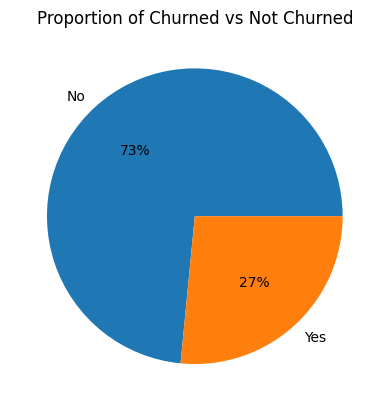

In [5]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [6]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Distribution

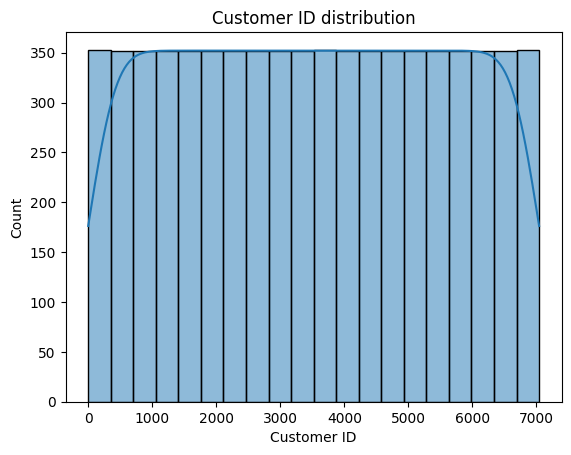

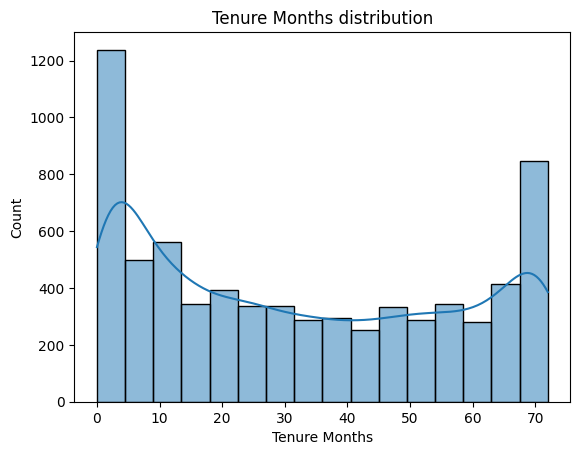

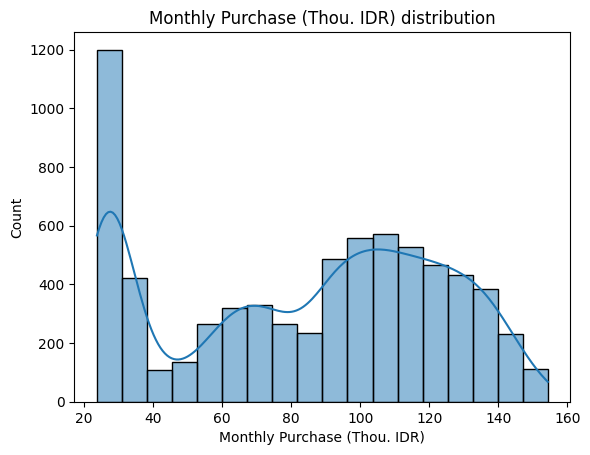

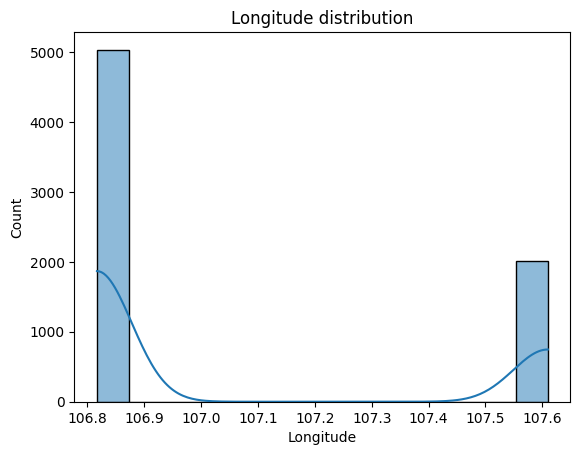

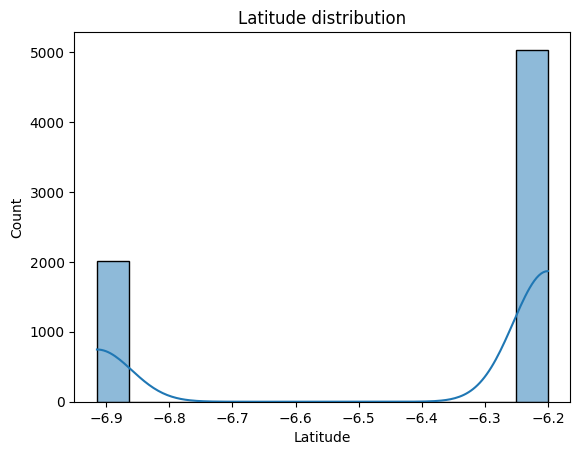

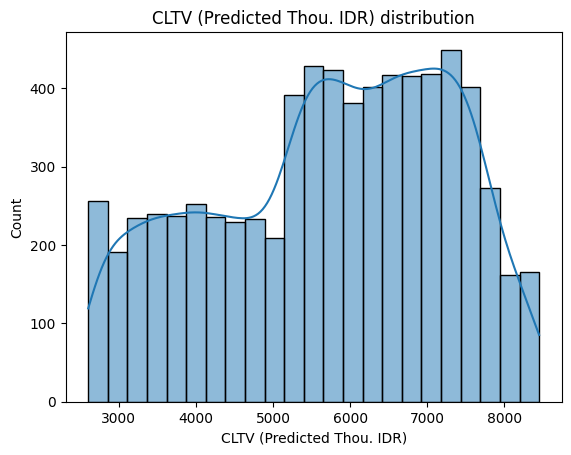

In [7]:
for c in df.select_dtypes(include=[int, float]):
    sns.histplot(df[c], kde=True)
    plt.title(f"{c} distribution")
    plt.show()

## Device Class

[Text(0.5, 0, 'Churn Label'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Device Class vs Churn Label')]

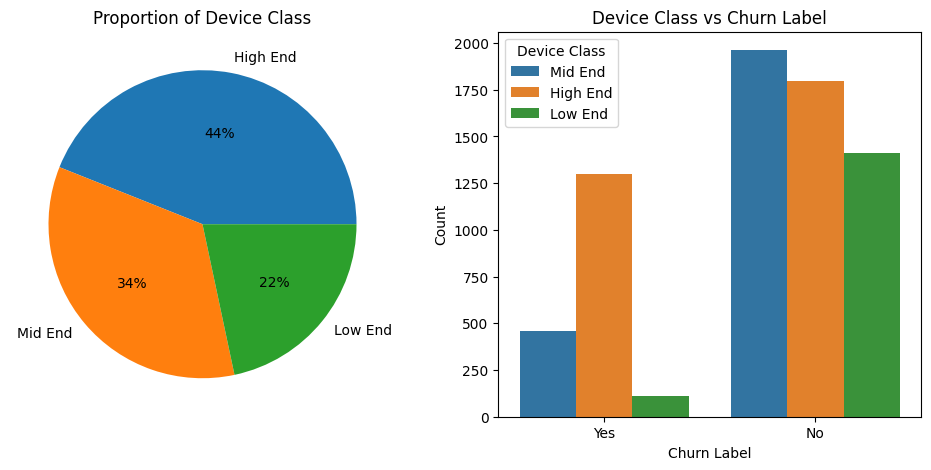

In [8]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
plot_df = df["Device Class"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Device Class")

# Device Class vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Device Class', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Device Class vs Churn Label")

1. `~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn.
2. The proportion is dominated by **High End**, followed by **Mid End** and **Low End**

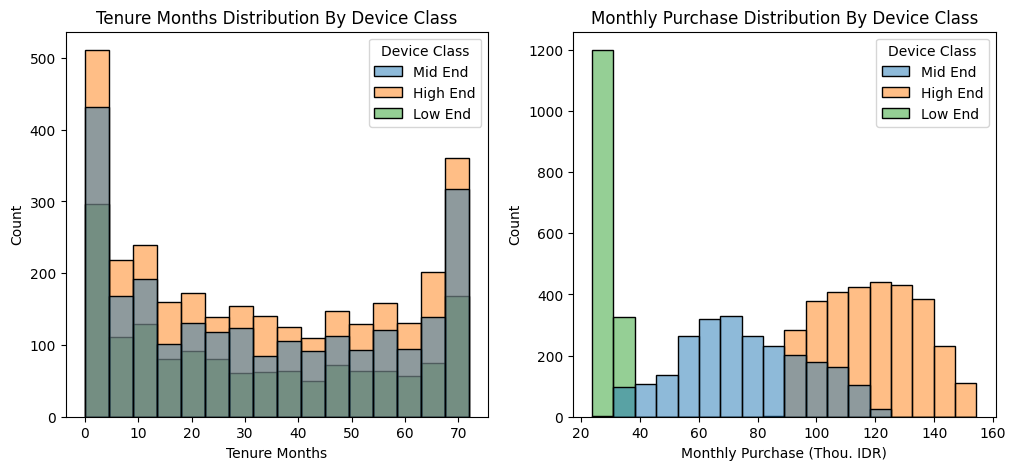

In [9]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
sns.histplot(data=df, x="Tenure Months", hue="Device Class", ax=ax[0])
ax[0].set_title("Tenure Months Distribution By Device Class")

# Device Class vs Churn Label
# =================================================================
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Device Class", ax=ax[1])
ax[1].set_title("Monthly Purchase Distribution By Device Class")
plt.show()

1. Tenure Months By `Device Class` is distributed evenly.
2. `Device Class` split the distribution of `Monthly Purchase` three groups.  

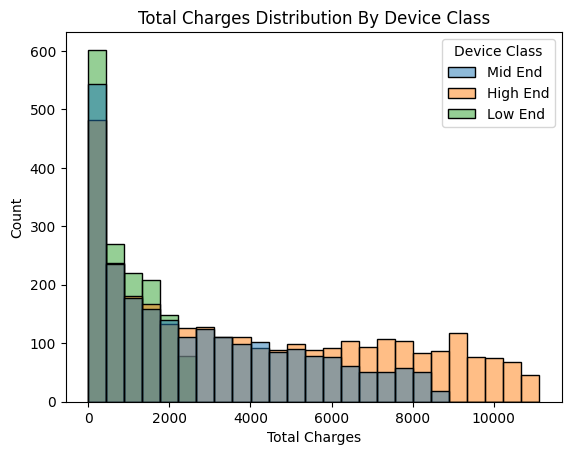

In [10]:
df["Total Charges"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]

# Proportion of the Device Class
# =================================================================
sns.histplot(data=df, x="Total Charges", hue="Device Class")
plt.title("Total Charges Distribution By Device Class")
plt.show()

## Location

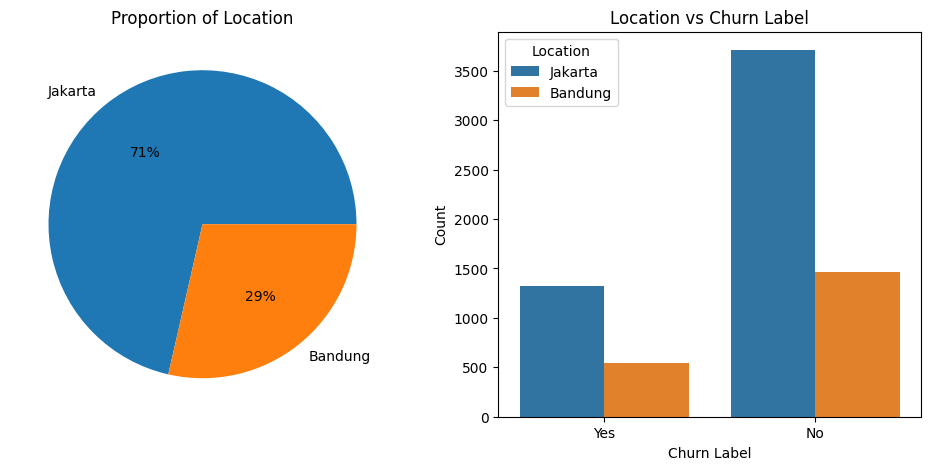

In [11]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Location
# =================================================================
plot_df = df["Location"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Location")

# Location vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Location', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Location vs Churn Label")
plt.show()

In [12]:
location_churn = df.pivot_table(values="Customer ID", index="Churn Label", columns="Location", aggfunc="count", margins=True)
location_churn / location_churn.loc["All", :]

Location,Bandung,Jakarta,All
Churn Label,,,
No,0.728628,0.73703,0.73463
Yes,0.271372,0.26297,0.26537
All,1.000000,1.00000,1.00000


1. Jakarta has the highes churn rate, but It's due to inequality of proportion between users from **Jakarta** and **Bandung**
2. The changes of user either from `Bandung` and `Jakarta` are almost the same. 

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [13]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

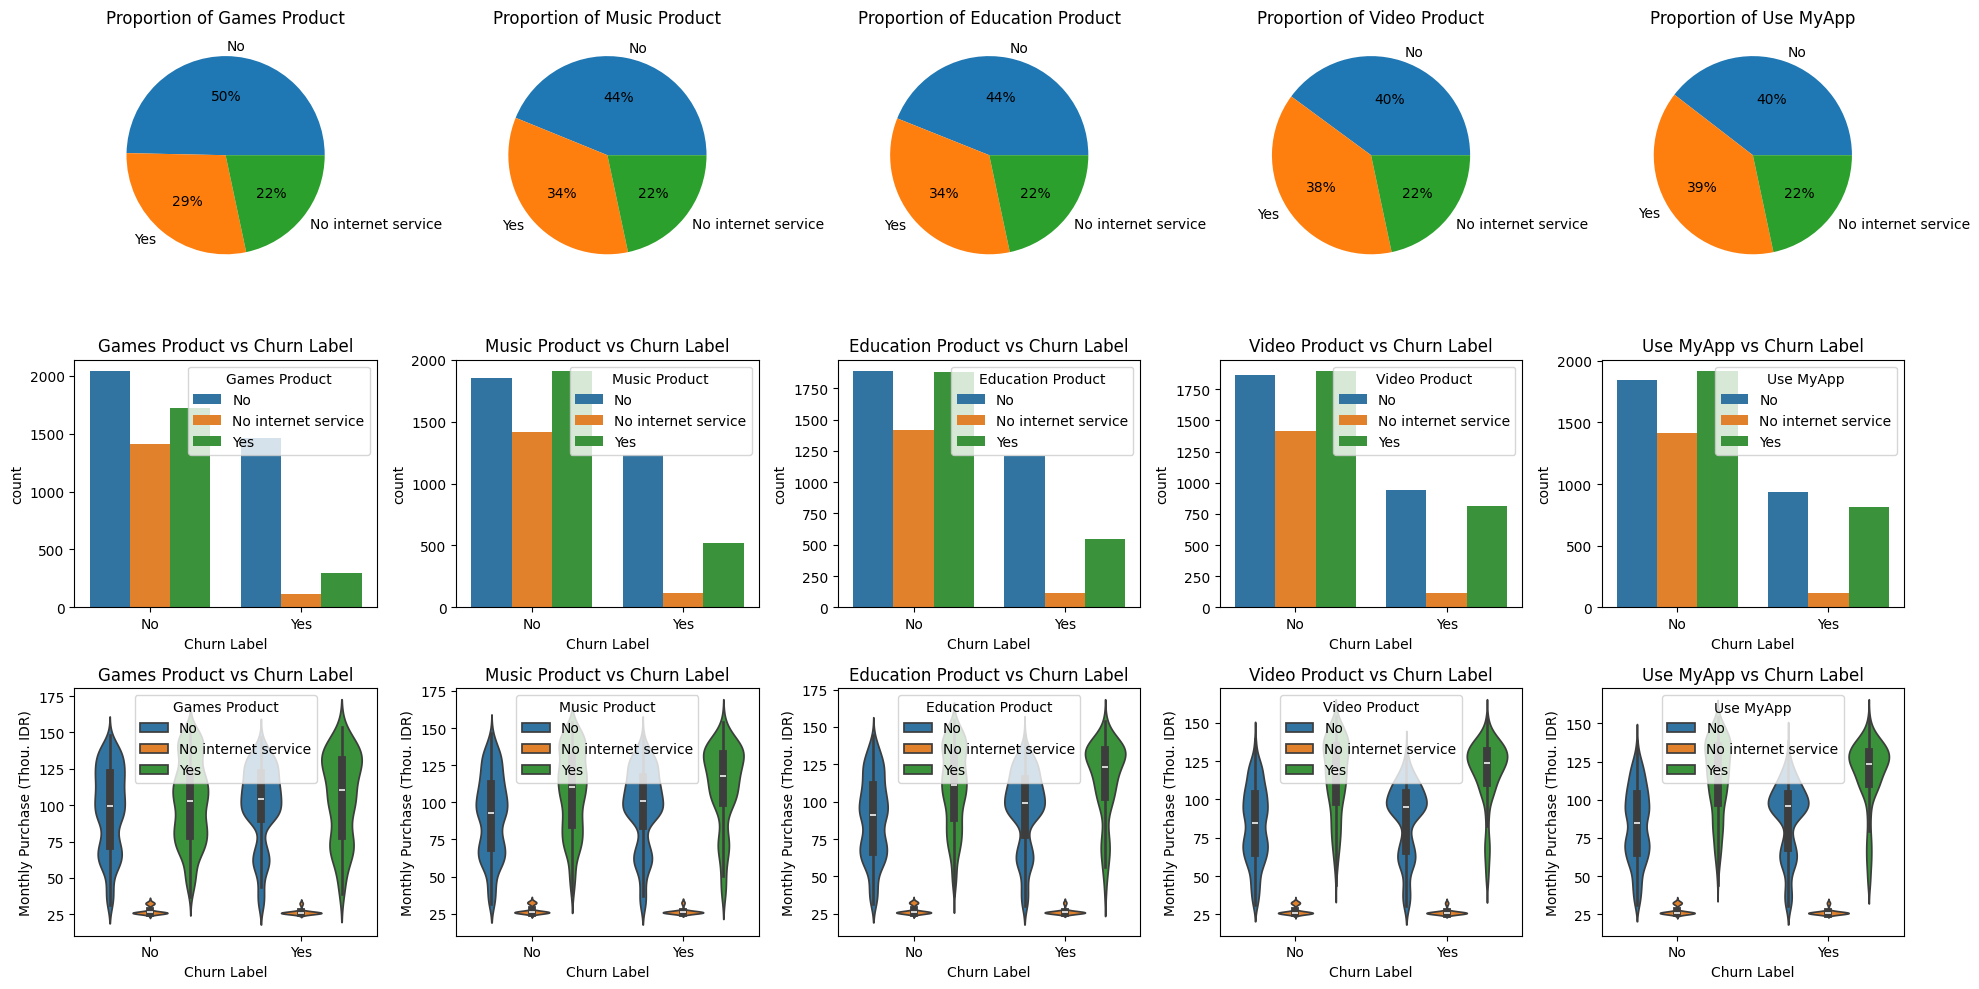

In [14]:

cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 10))

for i, c in enumerate(cols):
    plot_df = df[c].value_counts(normalize=True) * 100
    ax[0][i].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
    ax[0][i].set_title(f"Proportion of {c}")
    

for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', hue=c, ax=ax[1][i])
    ax[1][i].set_title(f"{c} vs Churn Label")
    
    
for i, c in enumerate(cols):
    sns.violinplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', y="Monthly Purchase (Thou. IDR)", hue=c, ax=ax[2][i])
    ax[2][i].set_title(f"{c} vs Churn Label")

fig.tight_layout()

1. People who didn't use internet service for Games, Music, and Education Product has a higher change of churn.
2. People who's monthly purchase is around **100K** and didn't use the internet service for using any of the products has more change of churning
3. People who's monthly purchase is around **125K** and didn't use the internet service for using any of the products has more change of churning

Users who churned they don't use the internet service for accessing those products

## Payment Method

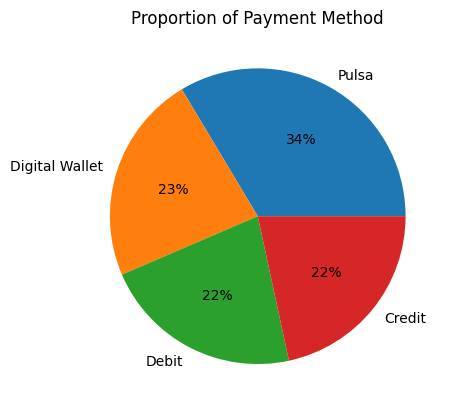

In [15]:
plot_df = df["Payment Method"].value_counts(normalize=True) * 100
plt.pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
plt.title(f"Proportion of Payment Method")
plt.show()

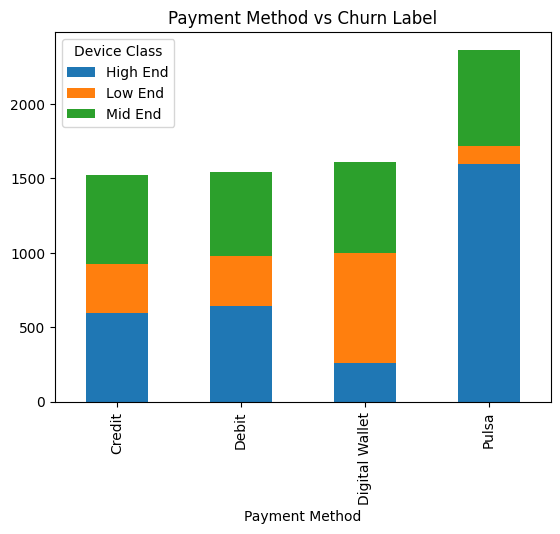

In [16]:
plot_df = df.pivot_table(index="Payment Method", columns="Device Class", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

In [17]:
churn_payment_method = df.pivot_table(columns="Payment Method", index="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Payment Method,Credit,Debit,Digital Wallet,Pulsa
Churn,,,,
0,0.847569,0.832902,0.808933,0.547146
1,0.152431,0.167098,0.191067,0.452854


1. Users buy using pulsa has high change of churn

## Tenure Months

In [18]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


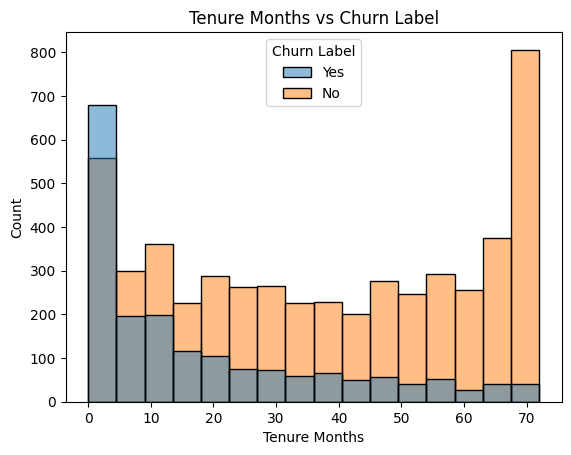

In [19]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

User with low tenure has a high change of churning

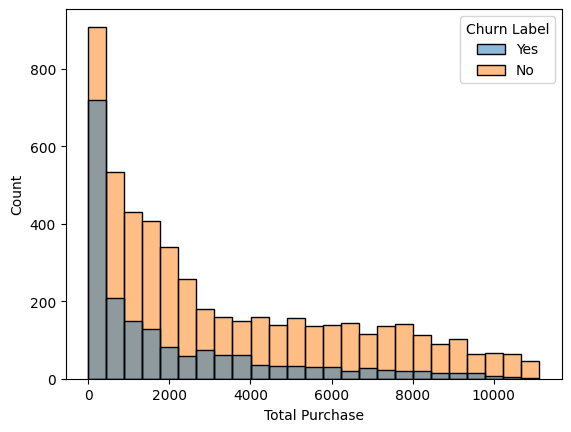

In [20]:
sns.histplot(data=df, x="Total Purchase", hue="Churn Label")
plt.show()

## Monthly Purchase

In [21]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

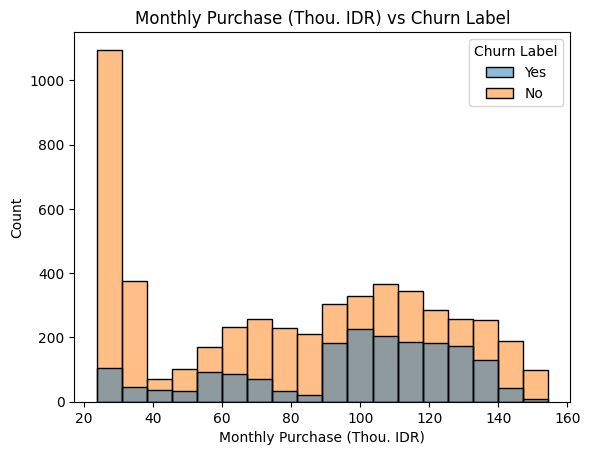

In [22]:
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 90,000.00 - Rp 140,000.00 a month. The central tendency is there

## CLTV

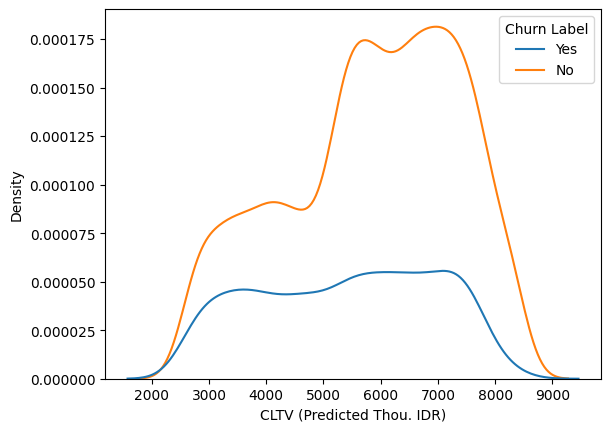

In [23]:
sns.kdeplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature.

## Call Center
Check whether the customer uses the call center service

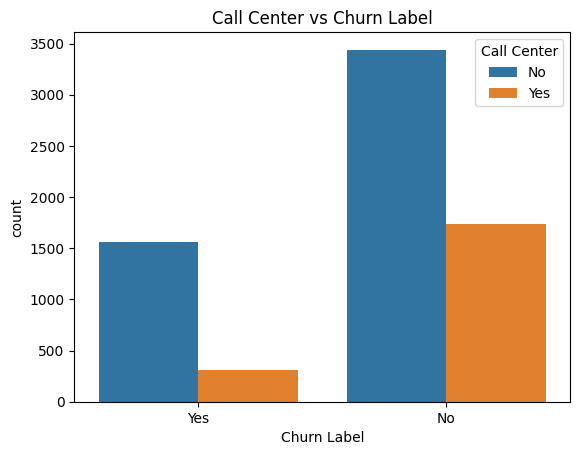

In [24]:
sns.countplot(data=df, x="Churn Label", hue="Call Center")
plt.title("Call Center vs Churn Label")
plt.show()

## Total Purchase

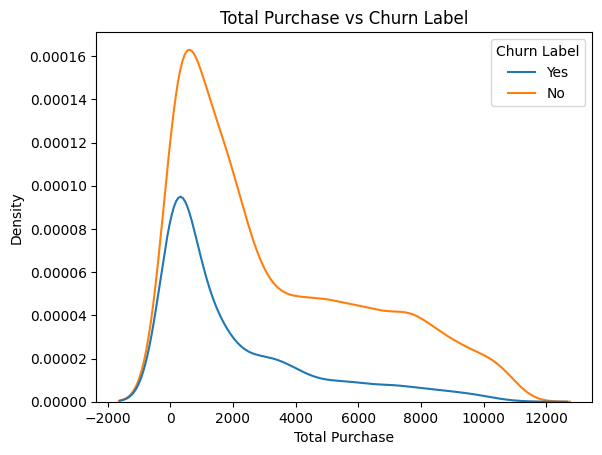

In [25]:
sns.kdeplot(data=df, x="Total Purchase", hue="Churn Label")
plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

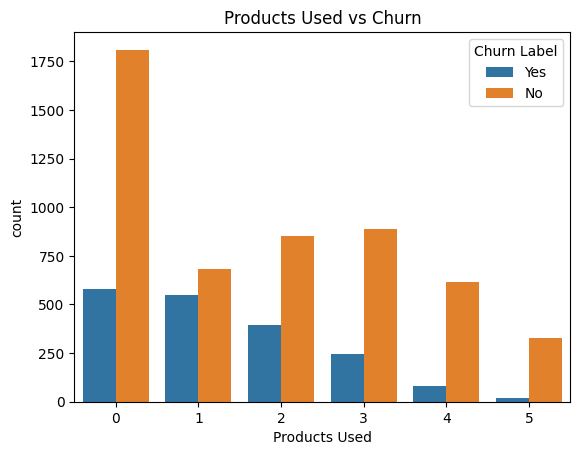

In [26]:
def uses_internet_for_product(data):
    if data == "Yes": return 1
    return 0

# Total Product Used
df_ori["Products Used"] = df_ori[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Call Center'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)

sns.countplot(data=df_ori, x="Products Used", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show()

In [27]:
df_ori["Monthly Purchase per Item"] = df_ori["Monthly Purchase (Thou. IDR)"] / (df_ori["Products Used"]+1)

0       23.335000
1       91.910000
2       43.181667
3       34.060000
4       33.702500
          ...    
7038    27.495000
7039    22.048000
7040    33.540000
7041    19.240000
7042    27.469000
Length: 7043, dtype: float64

User that pay more and use little of the product services has a high chance of churning

## Correlation Map

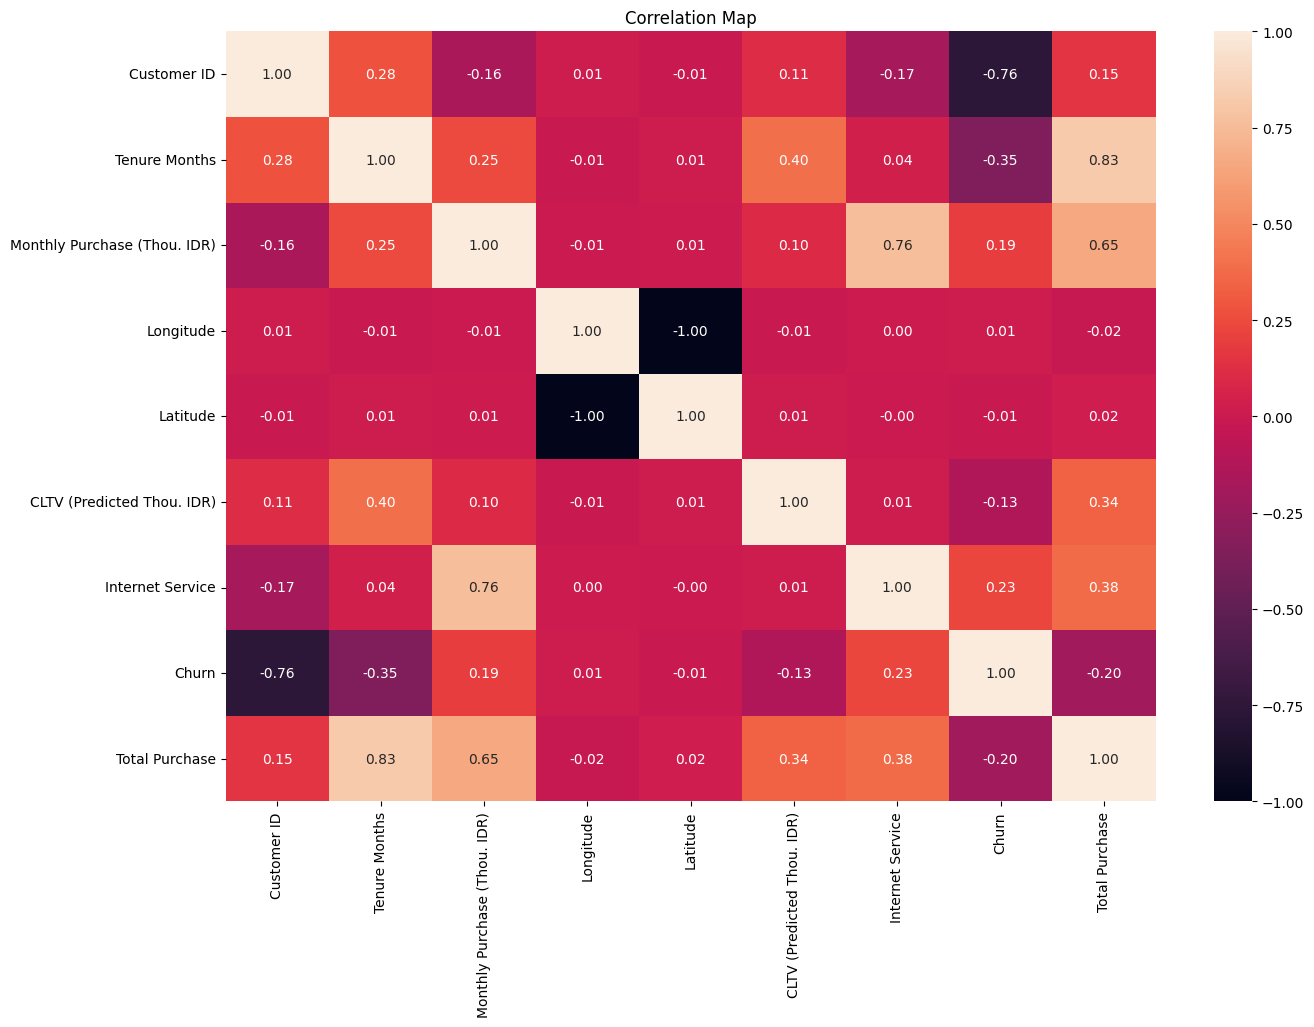

In [28]:
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [35]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

## Data Preparation

In [41]:
# change label of product and app
df = df_ori.copy()
df['Churn Label'] = df['Churn Label'].replace({"Yes": "1", "No": "0"}).astype(int)

# ordinal encoding
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)

# one hot encoding
df = pd.get_dummies(df, columns=['Payment Method', 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp', 'Location', 'Call Center'], dtype=int)

# drop data
df = df.drop(columns=["Customer ID"])

# split data to train and test
X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val, shuffle=True)

# scaling
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [42]:
# Functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression

# calculate precision, recall, f1 score
def evaluate(model, y_true, y_pred, y_pred_proba):
    print(f"""
        METRICS
        Precision: {precision_score(y_true, y_pred)}
        Recall: {recall_score(y_true, y_pred)}
        F1 Score: {f1_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC AUC score
    print(f"ROC AUC score: {roc_auc_score(y_true, y_pred)}")

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()
    

def baseline_model(X_train, y_train, X_val, y_val):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    evaluate(model, y_val, y_pred, y_pred_proba)

    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_val.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.show()

## Baseline Model 


        METRICS
        Precision: 0.6242424242424243
        Recall: 0.5508021390374331
        F1 Score: 0.5852272727272727
    


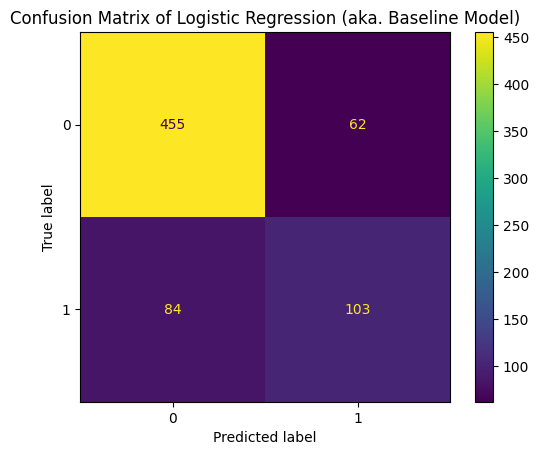

ROC AUC score: 0.7154397542382523


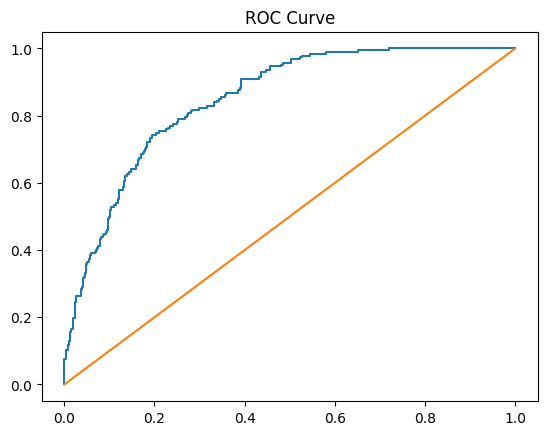

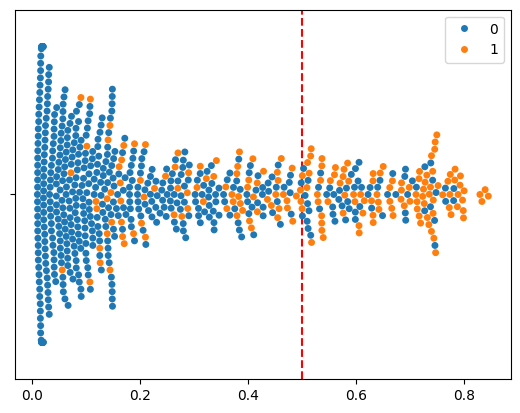

In [ ]:
baseline_model(X_train, y_train, scaler.transform(X_val), y_val)

1. For churn we would focus on `precision` because we want to identify as much as customer that wanted to churn as possible bcause there's nothing wrong with applying retentioin campaign to customers that don't churn.
2. `ROC AUC score` is also important that because that determines how well our model in **discriminate** customers who churn and not.
3. Swarm plot labels indicate that a lot of actual churn customers don't have a high probability of churn

## Model Improvement

### 1. Feature Engineering

In [39]:
# change label of product and app
df = df_ori.copy()
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

def uses_internet_for_product(data):
    if data == "Yes": return 1
    return 0

# change label of product and app
df = df_ori.copy()

# generate new features    
df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
df["ProductsUsed"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Call Center'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)
df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)

# Encoding
df['Churn Label'] = df['Churn Label'].replace({"Yes": "1", "No": "0"}).astype(int)

# Ordinal encoding
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)

# One hot encoding
df = pd.get_dummies(df, columns=['Payment Method', 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp', 'Location', 'Call Center'], dtype=int)

# drop data
df = df.drop(columns=["Customer ID", "Longitude", "Latitude"])

# split data to train and test
X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val, shuffle=True)

# scaling
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

/home/awmarcel/anaconda3/envs/ml-tools/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



        METRICS
        Precision: 0.6303030303030303
        Recall: 0.5561497326203209
        F1 Score: 0.5909090909090908
    


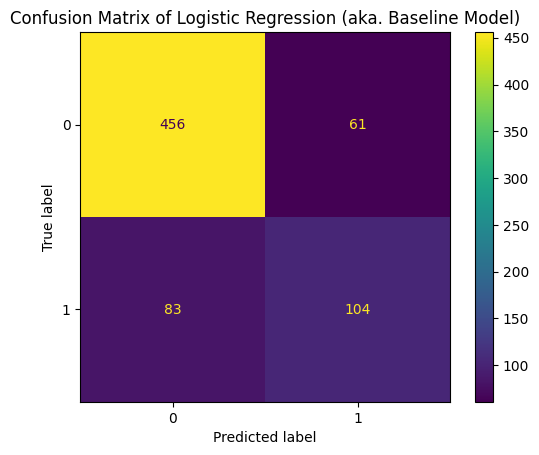

ROC AUC score: 0.7190806690180909


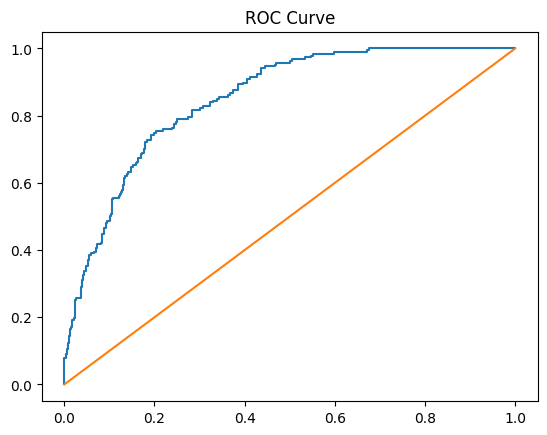

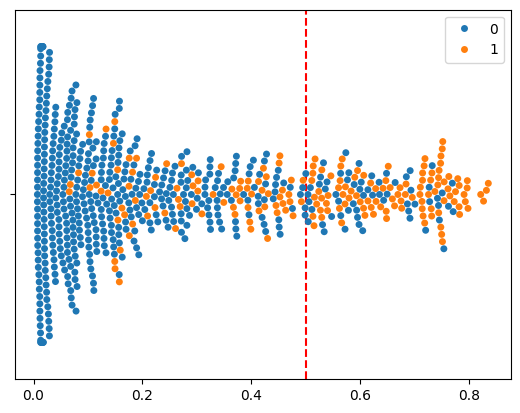

In [40]:
baseline_model(X_train, y_train, scaler.transform(X_val), y_val)

Validate on Other Models

In [ ]:
# # classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

models = [
    LogisticRegression(random_state=42), DecisionTreeClassifier(random_state=42), 
    RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42), 
    GradientBoostingClassifier(random_state=42), XGBClassifier(random_state=42),
    CatBoostClassifier(random_state=42), LGBMClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []
threshold=0.5

for model in models:
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(scaler.transform(X_val))
    y_pred = [1 if proba > threshold else 0 for proba in y_pred_proba[:, 1]]
    recalls.append(recall_score(y_val, y_pred))
    precisions.append(recall_score(y_val, y_pred))
    f1s.append(recall_score(y_val, y_pred))
    roc_aucs.append(roc_auc_score(y_val, y_pred))
    
df_model = pd.DataFrame(
    {
        "Model Name": [model.__class__.__name__ for model in models],
        "Threshold": [threshold for _ in range(len(models))],
        "Recall": recalls,
        "Precisions": precisions,
        "F1 Score": f1s,
        "ROC AUC Score": roc_aucs,
    }
)

df_model

### Perform Oversampling
Oversampling is used to tackle imbalance class problem

#### 1. SMOTE: Synthetic Minority Oversampling Technique

In [ ]:
# change label of product and app
df = df_ori.copy()

def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

def uses_internet_for_product(data):
    if data == "Yes": return 1
    return 0


# generate new features    
# df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
# df['Total Purchases'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
# df["ProductsUsed"] = df[['Games Product', 'Music Product', 'Education Product', 'Call Center', 'Video Product', 'Use MyApp']]\
#     .apply(lambda x: uses_internet_for_product(x['Games Product'])
#         + uses_internet_for_product(x['Music Product'])
#         + uses_internet_for_product(x['Education Product'])
#         + uses_internet_for_product(x['Call Center'])
#         + uses_internet_for_product(x['Use MyApp']), axis=1)

# Encoding
df['Churn Label'] = df['Churn Label'].replace({"Yes": "1", "No": "0"}).astype(int)

# Ordinal encoding
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)

# One hot encoding
df = pd.get_dummies(df, columns=['Payment Method', 'Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp', 'Location', 'Call Center'], dtype=int)

# drop data
df = df.drop(columns=["Customer ID", "Longitude", "Latitude"])

# split data to train and test
X, y = df.drop(columns=["Churn Label"]), df["Churn Label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val, shuffle=True)

# Oversample train data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# scaling
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

Test on Baseline Models

In [ ]:
baseline_model(X_train, y_train, scaler.transform(X_val), y_val)

Validate on Other Models

In [ ]:
# # classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

models = [
    LogisticRegression(random_state=42), DecisionTreeClassifier(random_state=42), 
    RandomForestClassifier(random_state=42), AdaBoostClassifier(random_state=42), 
    GradientBoostingClassifier(random_state=42), XGBClassifier(random_state=42),
    CatBoostClassifier(random_state=42), LGBMClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []
threshold=0.5

for model in models:
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(scaler.transform(X_val))
    y_pred = [1 if proba > threshold else 0 for proba in y_pred_proba[:, 1]]
    recalls.append(recall_score(y_val, y_pred))
    precisions.append(recall_score(y_val, y_pred))
    f1s.append(recall_score(y_val, y_pred))
    roc_aucs.append(roc_auc_score(y_val, y_pred))
    
df_model = pd.DataFrame(
    {
        "Model Name": [model.__class__.__name__ for model in models],
        "Threshold": [threshold for _ in range(len(models))],
        "Recall": recalls,
        "Precisions": precisions,
        "F1 Score": f1s,
        "ROC AUC Score": roc_aucs,
    }
)

df_model